In [74]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import mstats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from matplotlib.pyplot import figure

In [2]:
data = pd.read_excel('Final dataset for real2.xlsx', index_col = 0)
data = data.reset_index()

In [3]:
data.count()

Company name           21233
Country ISO code       21233
Nr. of Tax Treaties    21233
NACE Rev. 2            21170
Operating revenue      19609
Number of employees    13013
PBT                    21233
Total assets           21224
ROA                    19716
No of subsidiaries     21233
Solvency ratio         20407
Long term debt         18793
Debtors                21121
Current liabilities    21132
Size                   21233
Accounting practice    21233
Degree                 18639
Closeness              18639
Betweenness            18639
Eigenvector            18639
Hubs                   18639
ETR                    21233
dtype: int64

In [77]:
data['Country ISO code'] = data['Country ISO code'].astype('category')
data['Size'] = data['Size'].astype('category')
data['Accounting practice'] = data['Accounting practice'].astype('category')
data['NACE Rev. 2'] = data['NACE Rev. 2'].astype('category')

X = data[["Country ISO code","Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector","Hubs"]]
y = data["ETR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 2031996, shuffle = True)

X_train_con = X_train[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_train_cat = X_train[['NACE Rev. 2', 'Size', 'Accounting practice']]

scaler = StandardScaler()
scaler.fit(X_train_con)
StandardScaler()
X_train_con = scaler.transform(X_train_con)

iim=IterativeImputer(#estimator=xgb.XGBRegressor(),
initial_strategy='median',
max_iter=10,
missing_values= np.nan,
random_state=2031996)

imputed_X_train_con = pd.DataFrame(iim.fit_transform(X_train_con), index = X_train.index)
imputed_X_train_con.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

imputed_X_train_cat = pd.get_dummies(X_train_cat)
imputed_X_train = pd.concat([imputed_X_train_con, imputed_X_train_cat], axis = 1)

drop_na = pd.concat([imputed_X_train, y_train], axis = 1)
drop_na = drop_na.dropna()
drop_na = pd.DataFrame(drop_na)

X_train_final = drop_na.loc[:,:'Accounting practice_US GAAP']
y_train_final = drop_na['ETR']

X_test_con = X_test[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_test_cat = X_test[['NACE Rev. 2', 'Size', 'Accounting practice']]

X_test_con = scaler.transform(X_test_con)

imputed_X_test_con = pd.DataFrame(iim.transform(X_test_con), index = X_test.index)
imputed_X_test_con.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

imputed_X_test_cat = pd.get_dummies(X_test_cat)
imputed_X_test = pd.concat([imputed_X_test_con, imputed_X_test_cat], axis = 1)

drop_na = pd.concat([imputed_X_test, y_test], axis = 1)
#drop_na = drop_na.dropna()
drop_na = pd.DataFrame(drop_na)

X_test_final = drop_na.loc[:,:'Accounting practice_US GAAP']
y_test_final = drop_na['ETR']

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
print('Imputed' , X_train_final.shape, y_train_final.shape)

Train (16986, 20) (16986,)
Test (4247, 20) (4247,)
Imputed (16986, 28) (16986,)


In [78]:
def winsorize(dataframe, upper, lower, column_to_winsor):
    dataframe = dataframe.sort_values(column_to_winsor, ascending=False, ignore_index = True)
    amount = dataframe[column_to_winsor].count()
    up = int(amount * (upper/100))
    low = int(amount * (lower/100))
    data_winsor = dataframe.loc[low:up]
    return data_winsor

data_winsor = winsorize(data, 99,  1, 'ETR') 
data_winsor = winsorize(data_winsor, 99, 1, "Operating revenue")
data_winsor = winsorize(data_winsor, 99, 1, "Total assets")
data_winsor = winsorize(data_winsor, 99, 1, "Current liabilities")
data_winsor = winsorize(data_winsor, 99, 1, "Betweenness")
data_winsor = winsorize(data_winsor, 99, 1, "Long term debt")
data_winsor = winsorize(data_winsor, 99, 1, "PBT")

X_winsor = data_winsor[["Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector","Hubs"]]
y_winsor = data_winsor["ETR"]

X_train_winsor, X_test_winsor, y_train_winsor, y_test_winsor = train_test_split(X_winsor, y_winsor, test_size=0.20, random_state= 2031996, shuffle = True)

X_train_con_winsor = X_train_winsor[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_train_cat_winsor = X_train_winsor[['NACE Rev. 2', 'Size', 'Accounting practice']]

scaler = StandardScaler()
scaler.fit(X_train_con_winsor)
StandardScaler()
X_train_con_winsor = scaler.transform(X_train_con_winsor)

iim=IterativeImputer(#estimator=xgb.XGBRegressor(),
initial_strategy='median',
max_iter=10,
missing_values= np.nan,
#skip_complete=True,
random_state=2031996)

imputed_X_train_con_winsor = pd.DataFrame(iim.fit_transform(X_train_con_winsor), index = X_train_winsor.index)
imputed_X_train_con_winsor.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

#imputed_X_train = imputed_X_train.dropna()
imputed_X_train_cat_winsor = pd.get_dummies(X_train_cat_winsor)
imputed_X_train_winsor = pd.concat([imputed_X_train_con_winsor, imputed_X_train_cat_winsor], axis = 1)

drop_na_winsor = pd.concat([imputed_X_train_winsor, y_train_winsor], axis = 1)
drop_na_winsor = drop_na_winsor.dropna()
drop_na_winsor = pd.DataFrame(drop_na_winsor)

X_train_final_winsor = drop_na_winsor.loc[:,:'Accounting practice_US GAAP']
y_train_final_winsor = drop_na_winsor['ETR']

X_test_con_winsor = X_test_winsor[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_test_cat_winsor = X_test_winsor[['NACE Rev. 2', 'Size', 'Accounting practice']]

X_test_con_winsor = scaler.transform(X_test_con_winsor)

imputed_X_test_con_winsor = pd.DataFrame(iim.transform(X_test_con_winsor), index = X_test_winsor.index)
imputed_X_test_con_winsor.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

imputed_X_test_cat_winsor = pd.get_dummies(X_test_cat_winsor)
imputed_X_test_winsor = pd.concat([imputed_X_test_con_winsor, imputed_X_test_cat_winsor], axis = 1)

drop_na_winsor = pd.concat([imputed_X_test_winsor, y_test_winsor], axis = 1)
#drop_na = drop_na.dropna()
drop_na_winsor = pd.DataFrame(drop_na_winsor)

X_test_final_winsor = drop_na_winsor.loc[:,:'Accounting practice_US GAAP']
y_test_final_winsor = drop_na_winsor['ETR']

print('Train', X_train_winsor.shape, y_train_winsor.shape)
print('Test', X_test_winsor.shape, y_test_winsor.shape)
print('Imputed train' , X_train_final_winsor.shape, y_train_final_winsor.shape)
print('Imputed test' , X_test_final_winsor.shape, y_test_final_winsor.shape)

Train (11108, 19) (11108,)
Test (2778, 19) (2778,)
Imputed train (11108, 28) (11108,)
Imputed test (2778, 28) (2778,)


In [79]:
def winsorize(dataframe, upper, lower, column_to_winsor):
    dataframe = dataframe.sort_values(column_to_winsor, ascending=False, ignore_index = True)
    amount = dataframe[column_to_winsor].count()
    up = int(amount * (upper/100))
    low = int(amount * (lower/100))
    data_winsor = dataframe.loc[low:up]
    return data_winsor

data_winsor2 = winsorize(data, 97.5,  4, 'ETR') 
data_winsor2 = winsorize(data_winsor2, 100,  4, "Operating revenue")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Total assets")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Current liabilities")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Betweenness")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Long term debt")
data_winsor2 = winsorize(data_winsor2, 97.5,  2.5, "PBT")

X_winsor2 = data_winsor2[["Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector","Hubs"]]
y_winsor2 = data_winsor2["ETR"]

X_train_winsor2, X_test_winsor2, y_train_winsor2, y_test_winsor2 = train_test_split(X_winsor2, y_winsor2, test_size=0.20, random_state= 2031996, shuffle = True)

X_train_con_winsor2 = X_train_winsor2[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_train_cat_winsor2 = X_train_winsor2[['NACE Rev. 2', 'Size', 'Accounting practice']]

scaler = StandardScaler()
scaler.fit(X_train_con_winsor2)
StandardScaler()
X_train_con_winsor2 = scaler.transform(X_train_con_winsor2)

iim=IterativeImputer(#estimator=xgb.XGBRegressor(),
initial_strategy='median',
max_iter=10,
missing_values= np.nan,
#skip_complete=True,
random_state=2031996)

imputed_X_train_con_winsor2 = pd.DataFrame(iim.fit_transform(X_train_con_winsor2), index = X_train_winsor2.index)
imputed_X_train_con_winsor2.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

#imputed_X_train = imputed_X_train.dropna()
imputed_X_train_cat_winsor2 = pd.get_dummies(X_train_cat_winsor2)
imputed_X_train_winsor2 = pd.concat([imputed_X_train_con_winsor2, imputed_X_train_cat_winsor2], axis = 1)

drop_na_winsor2 = pd.concat([imputed_X_train_winsor2, y_train_winsor2], axis = 1)
drop_na_winsor2 = drop_na_winsor2.dropna()
drop_na_winsor2 = pd.DataFrame(drop_na_winsor2)

X_train_final_winsor2 = drop_na_winsor2.loc[:,:'Accounting practice_US GAAP']
y_train_final_winsor2 = drop_na_winsor2['ETR']

X_test_con_winsor2 = X_test_winsor2[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_test_cat_winsor2 = X_test_winsor2[['NACE Rev. 2', 'Size', 'Accounting practice']]

X_test_con_winsor2 = scaler.transform(X_test_con_winsor2)

imputed_X_test_con_winsor2 = pd.DataFrame(iim.transform(X_test_con_winsor2), index = X_test_winsor2.index)
imputed_X_test_con_winsor2.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

imputed_X_test_cat_winsor2 = pd.get_dummies(X_test_cat_winsor2)
imputed_X_test_winsor2 = pd.concat([imputed_X_test_con_winsor2, imputed_X_test_cat_winsor2], axis = 1)

drop_na_winsor2 = pd.concat([imputed_X_test_winsor2, y_test_winsor2], axis = 1)
#drop_na = drop_na.dropna()
drop_na_winsor2 = pd.DataFrame(drop_na_winsor2)

X_test_final_winsor2 = drop_na_winsor2.loc[:,:'Accounting practice_US GAAP']
y_test_final_winsor2 = drop_na_winsor2['ETR']

print('Train', X_train_winsor2.shape, y_train_winsor2.shape)
print('Test', X_test_winsor2.shape, y_test_winsor2.shape)
print('Imputed train' , X_train_final_winsor2.shape, y_train_final_winsor2.shape)
print('Imputed test' , X_test_final_winsor2.shape, y_test_final_winsor2.shape)

Train (8877, 19) (8877,)
Test (2220, 19) (2220,)
Imputed train (8877, 28) (8877,)
Imputed test (2220, 28) (2220,)


In [ ]:
.isnull().sum()

In [80]:
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['rbf']

random_grid = {'C': C,
               'gamma': gamma,
               'kernel': kernel}

svr = SVR()
svr_random = GridSearchCV(estimator = svr, param_grid = random_grid, cv = 5, verbose=2, n_jobs = -1)
svr_random.fit(X_train_final, y_train_final)
best_parameters = svr_random.best_estimator_
print(best_parameters)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
SVR(C=1000, gamma=0.1)


In [81]:
C = [150, 200, 250]
gamma = [0.04]
kernel = ['rbf']

random_grid = {'C': C,
               'gamma': gamma,
               'kernel': kernel}

svr_winsor = SVR()
svr_random_winsor = GridSearchCV(estimator = svr_winsor, param_grid = random_grid, cv = 5, verbose=2, n_jobs = -1)
svr_random_winsor.fit(X_train_final_winsor, y_train_final_winsor)
best_parameters_winsor = svr_random_winsor.best_estimator_
print(best_parameters_winsor)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
SVR(C=250, gamma=0.04)


In [82]:
C = [700, 1000, 1300]
gamma = [0.04, 0.01, 0.005]
kernel = ['rbf']

random_grid = {'C': C,
               'gamma': gamma,
               'kernel': kernel}

svr_winsor2 = SVR()
svr_random_winsor2 = GridSearchCV(estimator = svr_winsor2, param_grid = random_grid, cv = 5, verbose=2, n_jobs = -1)
svr_random_winsor2.fit(X_train_final_winsor2, y_train_final_winsor2)
best_parameters_winsor2 = svr_random_winsor2.best_estimator_
print(best_parameters_winsor2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVR(C=1300, gamma=0.01)


In [87]:
svr_for_pred = SVR(C=1000, gamma=0.1)

svr_for_pred.fit(X_train_final,y_train_final)

y_pred = svr_for_pred.predict(X_test_final)

mae = mean_absolute_error(y_test_final, y_pred)
mse = mean_squared_error(y_test_final, y_pred)
rmse = np.sqrt(mse)
d_nonan = {'With outliers': [mse, rmse, mae]}
df_nonan = pd.DataFrame(d_nonan, index = ['MSE','RMSE','MAE'])
print(df_nonan)

      With outliers
MSE   127643.219635
RMSE     357.271913
MAE       31.573157


In [88]:
rf_for_pred_winsor = SVR(C=250, gamma=0.04)

rf_for_pred_winsor.fit(X_train_final_winsor,y_train_final_winsor)

y_pred_winsor = rf_for_pred_winsor.predict(X_test_final_winsor)

mae_winsor = mean_absolute_error(y_test_final_winsor, y_pred_winsor)
mse_winsor = mean_squared_error(y_test_final_winsor, y_pred_winsor)
rmse_winsor = np.sqrt(mse_winsor)
d_nonan_winsor = {'1% outliers removed': [mse_winsor, rmse_winsor, mae_winsor]}
df_nonan_winsor = pd.DataFrame(d_nonan_winsor, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor)

      1% outliers removed
MSE            771.560149
RMSE            27.776972
MAE             14.557903


In [90]:
rf_for_pred_winsor2 = SVR(C=150, gamma=0.04)

rf_for_pred_winsor2.fit(X_train_final_winsor2,y_train_final_winsor2)

y_pred_winsor2 = rf_for_pred_winsor2.predict(X_test_final_winsor2)

mae_winsor2 = mean_absolute_error(y_test_final_winsor2, y_pred_winsor2)
mse_winsor2 = mean_squared_error(y_test_final_winsor2, y_pred_winsor2)
rmse_winsor2 = np.sqrt(mse_winsor2)
d_nonan_winsor2 = {'5% outliers removed': [mse_winsor2, rmse_winsor2, mae_winsor2]}
df_nonan_winsor2 = pd.DataFrame(d_nonan_winsor2, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor2)

      5% outliers removed
MSE            209.328956
RMSE            14.468205
MAE              9.825845


In [91]:
results_LR = pd.concat([df_nonan, df_nonan_winsor, df_nonan_winsor2], axis = 1)
print(results_LR)

      With outliers  1% outliers removed  5% outliers removed
MSE   127643.219635           771.560149           209.328956
RMSE     357.271913            27.776972            14.468205
MAE       31.573157            14.557903             9.825845


In [93]:
results_LR.to_excel("results_SVM.xlsx")

In [113]:
y_error = pd.DataFrame(data = [(y_pred_winsor2-y_test_final_winsor2)]).T

In [114]:
y_error = pd.concat([X_test_final_winsor2, y_error], axis = 1)

In [115]:
cormat = y_error.corr()
round(cormat,3)

,Nr. of Tax Treaties,Operating revenue,Number of employees,PBT,Total assets,ROA,No of subsidiaries,Solvency ratio,Long term debt,Debtors,...,NACE Rev. 2_9.0,Size_Large company,Size_Medium sized company,Size_Small company,Size_Very large company,Accounting practice_IFRS,Accounting practice_IFRS - not fully compliant,Accounting practice_Local GAAP,Accounting practice_US GAAP,ETR
Nr. of Tax Treaties,1.000,-0.056,-0.049,0.012,-0.042,0.076,-0.012,0.016,-0.067,-0.022,...,0.034,-0.051,-0.036,-0.045,0.074,0.090,-0.021,0.221,-0.408,0.020
Operating revenue,-0.056,1.000,0.631,0.554,0.743,0.204,0.418,-0.070,0.462,0.749,...,-0.063,-0.072,-0.050,-0.036,0.095,-0.162,-0.007,0.095,0.088,-0.001
Number of employees,-0.049,0.631,1.000,0.412,0.584,0.148,0.439,-0.071,0.388,0.450,...,-0.031,-0.049,-0.036,-0.027,0.066,-0.043,0.001,-0.042,0.111,-0.024
PBT,0.012,0.554,0.412,1.000,0.605,0.420,0.368,0.093,0.379,0.499,...,0.006,-0.066,-0.036,-0.044,0.087,-0.016,-0.018,0.093,-0.101,-0.028
Total assets,-0.042,0.743,0.584,0.605,1.000,0.214,0.483,0.000,0.734,0.625,...,0.022,-0.071,-0.055,-0.034,0.096,-0.065,-0.006,-0.012,0.101,0.000
ROA,0.076,0.204,0.148,0.420,0.214,1.000,0.141,0.186,0.137,0.181,...,0.033,-0.022,-0.081,-0.025,0.067,-0.073,-0.003,0.171,-0.129,-0.007
No of subsidiaries,-0.012,0.418,0.439,0.368,0.483,0.141,1.000,-0.048,0.443,0.358,...,0.013,-0.040,-0.037,-0.029,0.061,0.047,0.022,-0.142,0.124,-0.023
Solvency ratio,0.016,-0.070,-0.071,0.093,0.000,0.186,-0.048,1.000,-0.173,-0.032,...,-0.000,-0.001,0.003,0.041,-0.015,-0.047,-0.037,0.098,-0.065,0.007
Long term debt,-0.067,0.462,0.388,0.379,0.734,0.137,0.443,-0.173,1.000,0.323,...,0.078,-0.044,-0.038,-0.039,0.069,0.037,0.003,-0.143,0.141,-0.002
Debtors,-0.022,0.749,0.450,0.499,0.625,0.181,0.358,-0.032,0.323,1.000,...,-0.065,-0.061,-0.044,-0.031,0.082,-0.173,-0.004,0.163,0.013,-0.036


In [118]:
ETR_heatmap = cormat['ETR']
ETR_heatmap = pd.DataFrame(ETR_heatmap)
ETR_heatmap.rename(columns = {'ETR':'ETR error'}, inplace = True)
ETR_heatmap = ETR_heatmap.drop('ETR')
ETR_heatmap

,ETR error
Nr. of Tax Treaties,0.019501
Operating revenue,-0.000837
Number of employees,-0.024273
PBT,-0.028185
Total assets,0.000011
ROA,-0.007281
No of subsidiaries,-0.022649
Solvency ratio,0.007280
Long term debt,-0.001660
Debtors,-0.035666


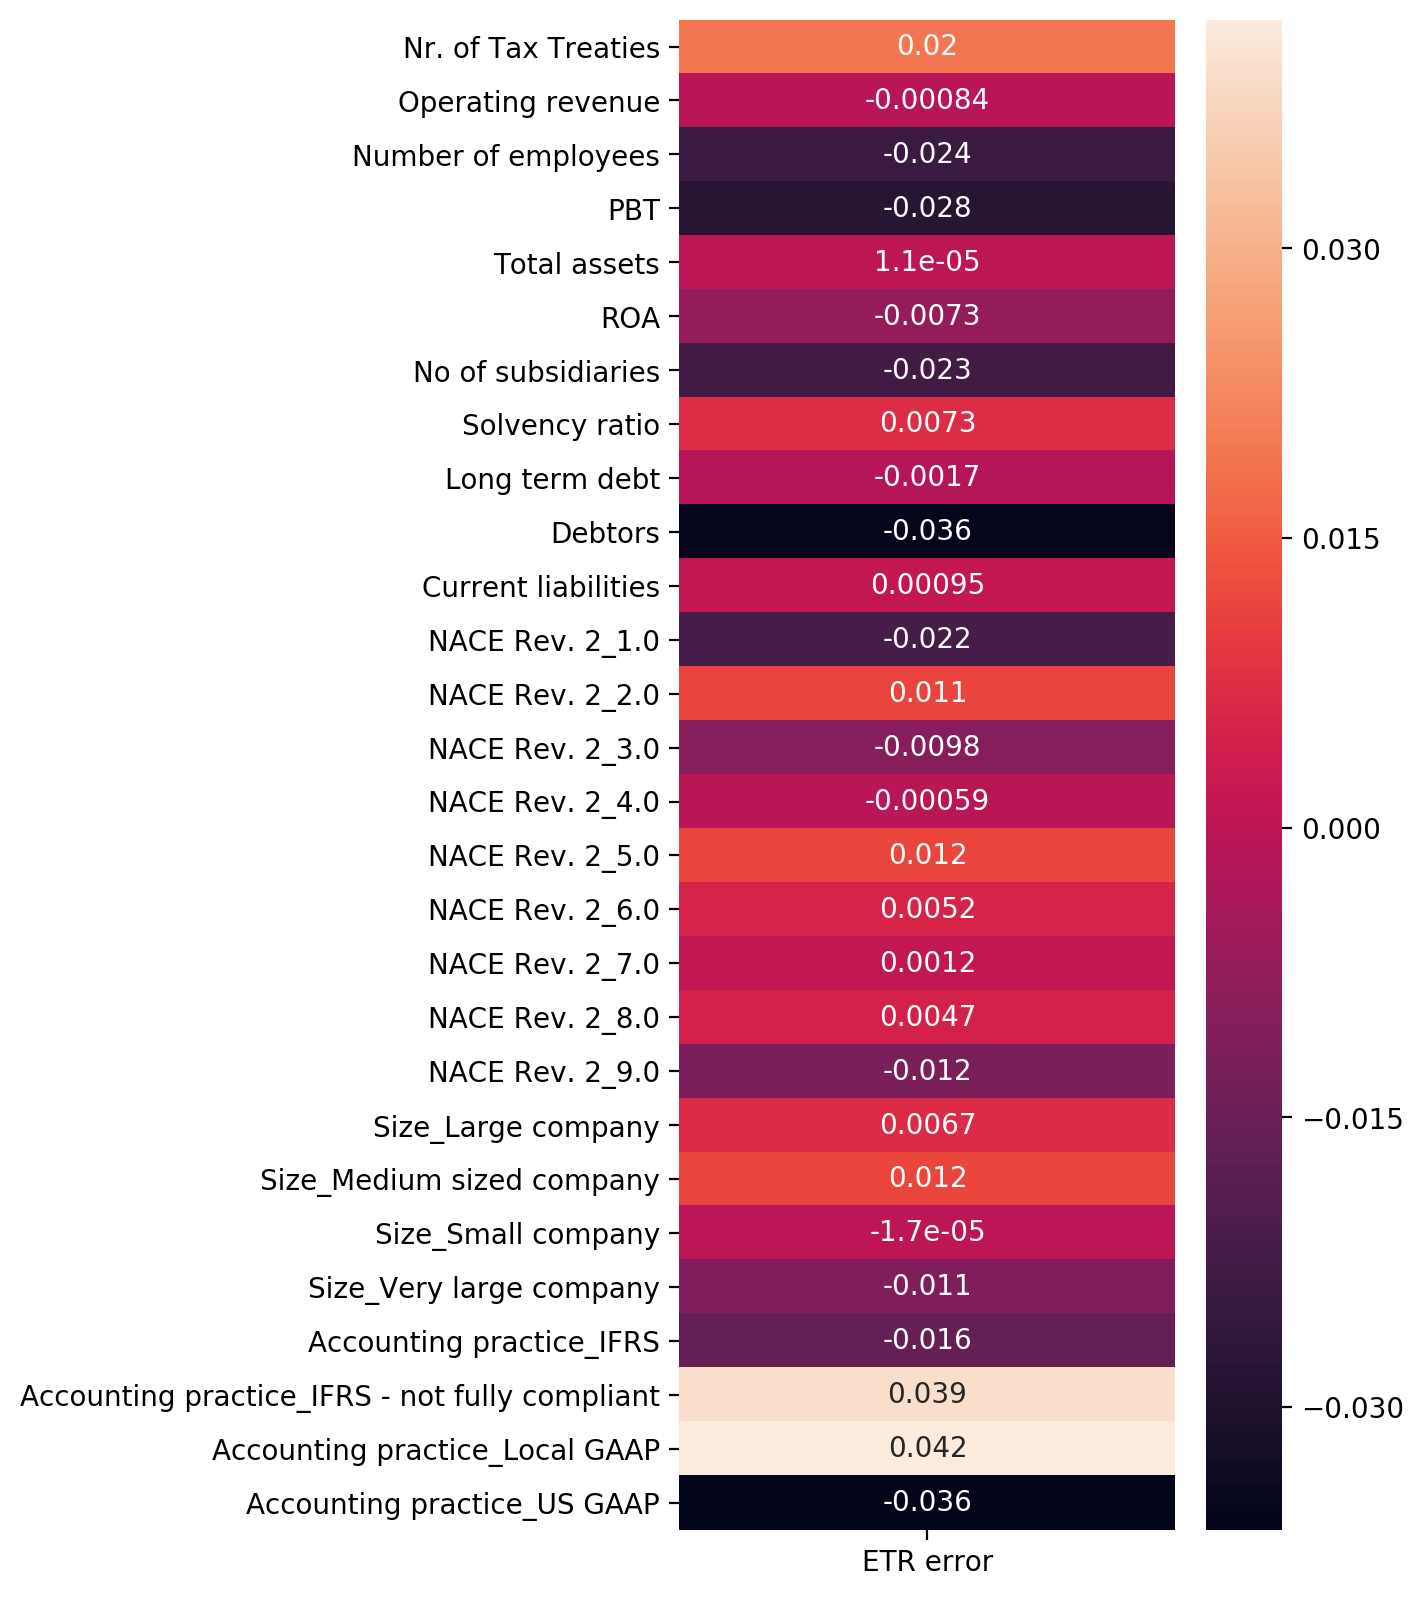

In [120]:
figure(figsize=(4, 10), dpi=200)
sns.heatmap(ETR_heatmap, annot = True)